# LECTURE 6: KNN

El Nino<br>
Dataset: //archive.ics.uci.edu/dataset/122/el+nino <br>
Your dataset should be unique from your classmates otherwise no points will be given for this exercise.

**DATA EXPLORATION**

In [133]:
from ucimlrepo import fetch_ucirepo
import numpy as np
import pandas as pd

# Fetching the dataset
solar_flare = fetch_ucirepo(id=89)

# Extracting features and targets
X = solar_flare.data.features
y = solar_flare.data.targets

# Creating a DataFrame from the features
df = pd.DataFrame(solar_flare.data.original, columns=solar_flare.data.headers)
cat_columns = ['modified Zurich class', 'largest spot size', 'spot distribution']
for col in cat_columns:
    df[col] = pd.Categorical(df[col]).codes
df

,modified Zurich class,largest spot size,spot distribution,activity,evolution,previous 24 hour flare activity,historically-complex,became complex on this pass,area,area of largest spot,common flares,moderate flares,severe flares
0,1,4,2,1,2,1,1,2,1,2,0,0,0
1,2,4,2,1,3,1,1,2,1,2,0,0,0
2,1,4,2,1,3,1,1,2,1,1,0,0,0
3,2,4,2,1,3,1,1,2,1,2,0,0,0
4,2,0,2,1,3,1,1,2,1,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1384,5,4,3,1,2,1,1,1,1,1,0,0,0
1385,5,4,3,2,2,1,1,2,1,1,0,0,0
1386,1,4,2,1,2,1,2,2,1,1,0,0,0
1387,5,3,3,1,2,1,1,2,1,1,0,0,0


In [134]:

# Mapping the target labels to 0s and 1s
df['common flares'] = df['common flares'].map({1: 0, 2: 1})

# Calculating the correlation matrix
correlation_matrix = df.corr().abs()

# Sorting correlations with target
correlation_with_target = correlation_matrix['common flares'].sort_values(ascending=False)

# Top 5 correlated frequencies with the target
top_correlated_features = correlation_with_target[1:6]  # Exclude the target itself


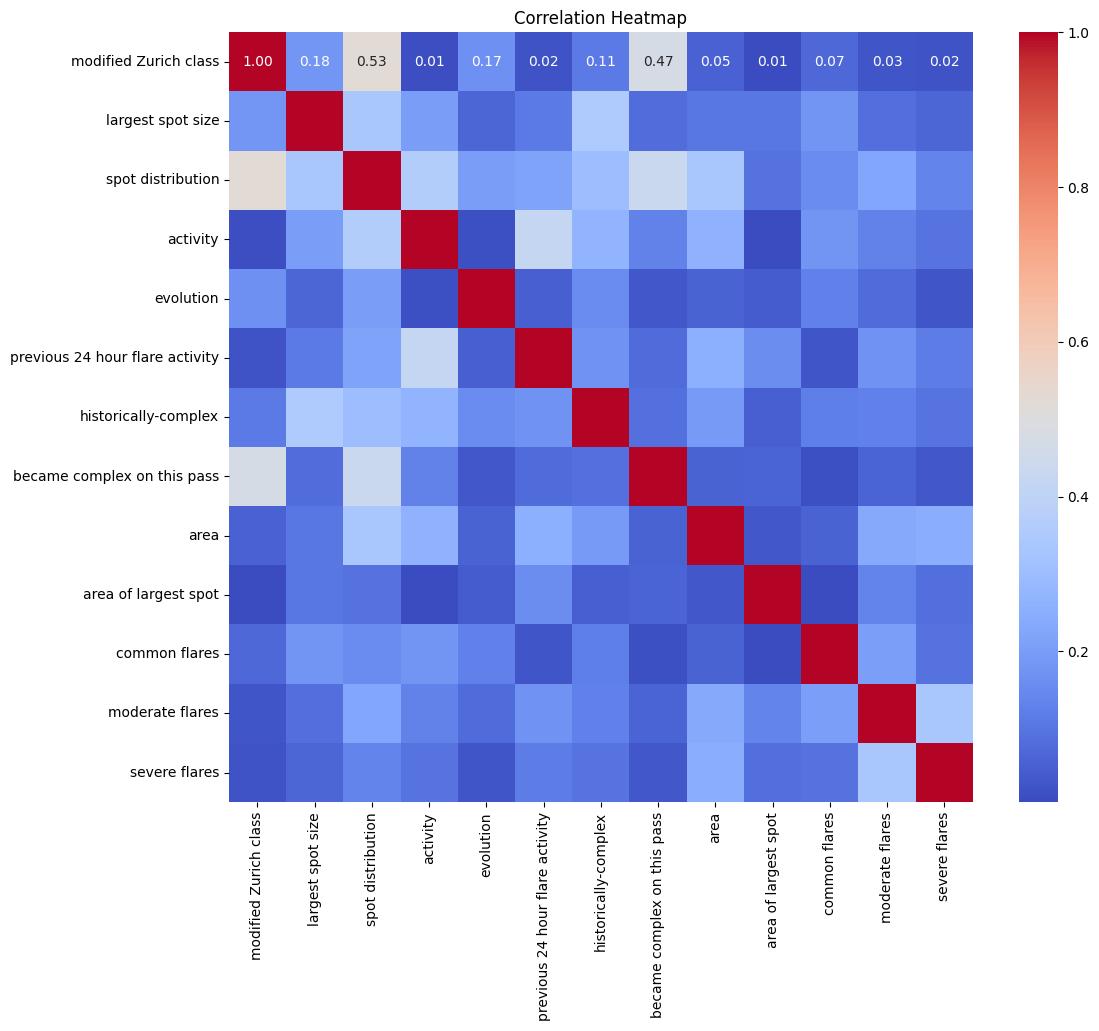

Top 5 correlated frequencies with the target:
moderate flares      0.203948
largest spot size    0.178479
activity             0.176410
spot distribution    0.154164
evolution            0.128389
Name: common flares, dtype: float64


In [135]:
import seaborn as sns
import matplotlib.pyplot as plt



plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

print("Top 5 correlated frequencies with the target:")
print(top_correlated_features)


## Train | Test Split

Our approach here will be one of using Cross Validation on 90% of the dataset, and then judging our results on a final test set of 10% to evaluate our model.


**
TASK: Split the data into features and labels, and then split into a training set and test set, with 90% for Cross-Validation training, and 10% for a final test se**
<br>
Note: Do not forget to put a random_state for reproducibility.t.

In [136]:
from sklearn.model_selection import train_test_split

# Splitting data into features and labels
X = df.drop(columns=['common flares'])
y = df['common flares']

# Splitting into training set and test set
X_train_cv, X_test, y_train_cv, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Further splitting training set into Cross-Validation training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_cv, y_train_cv, test_size=0.1, random_state=42)

# Check the shapes of the datasets
print("Training set shape:", X_train.shape, y_train.shape)
print("Cross-Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)


Training set shape: (1125, 12) (1125,)
Cross-Validation set shape: (125, 12) (125,)
Test set shape: (139, 12) (139,)


**TASK: Create a PipeLine that contains both a StandardScaler and a KNN model**

In [138]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer

# Checking for missing values in the target variable
print("Missing values in target variable (y):", y.isnull().sum())

# Impute missing values in target variable (if any)
imputer = SimpleImputer(strategy='most_frequent')
y_imputed = imputer.fit_transform(y.values.reshape(-1, 1)).ravel()
y = pd.Series(y_imputed, name=y.name)

# Splitting data into features and labels
X = df.drop(columns=['common flares'])

# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Creating pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

# Cross-validation on 90% of the dataset
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5)

# Fitting pipeline on full training data
pipeline.fit(X_train, y_train)

# Evaluating on the final test set
test_score = pipeline.score(X_test, y_test)

print("Cross Validation Scores:", cv_scores)
print("Mean CV Score:", np.mean(cv_scores))
print("Test Set Score:", test_score)


Missing values in target variable (y): 0
Cross Validation Scores: [0.968 0.972 0.968 0.964 0.968]
Mean CV Score: 0.968
Test Set Score: 0.9784172661870504


**TASK: Perform a grid-search with the pipeline to test various values of k and report back the best performing parameters.**

In [139]:
# Grid search parameters
param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9, 11],  # various values of k
    'knn__weights': ['uniform', 'distance'],
    'knn__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=9)
grid_search.fit(X_train, y_train)

# Report best performing parameters
print("Best performing parameters:")
print(grid_search.best_params_)

# Evaluate on test set
test_score = grid_search.score(X_test, y_test)
print("Test set accuracy:", test_score)

Best performing parameters:
{'knn__algorithm': 'auto', 'knn__n_neighbors': 7, 'knn__weights': 'uniform'}
Test set accuracy: 0.9784172661870504


**(HARD) TASK: Using the .cv_results_ dictionary, see if you can create a plot of the mean test scores per K value.**

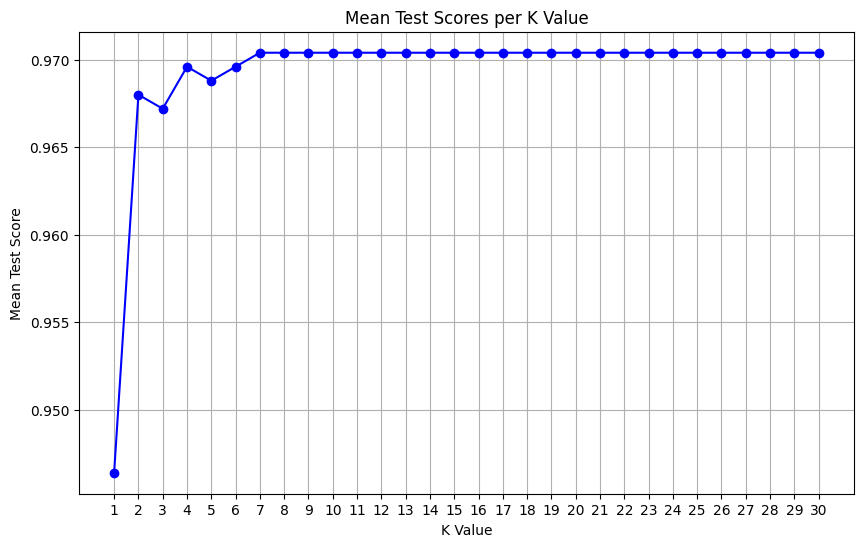

In [140]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

# Splitting the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Creating KNN classifier
knn = KNeighborsClassifier()

# Define a range of K values
k_values = list(range(1, 31))

# Parameters for grid search
param_grid = {'n_neighbors': k_values}

# Grid search using cross-validation on 90% of the dataset
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the mean test scores per K value
mean_test_scores = grid_search.cv_results_['mean_test_score']

# Plotting the mean test scores per K value
plt.figure(figsize=(10, 6))
plt.plot(k_values, mean_test_scores, marker='o', linestyle='-', color='b')
plt.xlabel('K Value')
plt.ylabel('Mean Test Score')
plt.title('Mean Test Scores per K Value')
plt.xticks(k_values)
plt.grid(True)
plt.show()


**TASK: Using the grid classifier object from the previous step, get a final performance classification report and confusion matrix.**

In [142]:
from sklearn.metrics import classification_report, confusion_matrix

# Predictions on the cleaned test set using the best model found by GridSearchCV
y_pred = grid_search.predict(X_test_clean)

# Classification report
print("Classification Report:")
print(classification_report(y_test_clean, y_pred, zero_division=0))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test_clean, y_pred))


Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       136
         1.0       0.00      0.00      0.00         3

    accuracy                           0.98       139
   macro avg       0.49      0.50      0.49       139
weighted avg       0.96      0.98      0.97       139

Confusion Matrix:
[[136   0]
 [  3   0]]
